In [26]:
import random
import pulp
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd 

In [27]:


def generate_projects(num_projects, num_tasks):
    projects = {}
    for i in range(1, num_projects + 1):
        tasks = {f'T{i}{j}': {'duration': random.randint(1, 10), 'workers': random.randint(1, 3)} for j in range(1, num_tasks + 1)}
        due_date = random.randint(6*num_tasks, 10*num_tasks)
        projects[f'P{i}'] = {'tasks': tasks, 'due_date': due_date}
    return projects

def generate_precedence_relations(projects):
    precedence_relations = {}
    for project, details in projects.items():
        tasks = list(details['tasks'].keys())
        for i in range(len(tasks)-1):
            if random.random() < 0.75:  # Randomly decide if a precedence relation exists
                precedence_relations.setdefault(tasks[i], set()).add(tasks[i+1])

    return precedence_relations

def generate_resources(num_employees, monthly_hours):
    return {
        'employees': num_employees,
        'monthly_hours': monthly_hours
    }

def optimize_schedule(projects, resources,planning_horizon):
    prob = pulp.LpProblem("ProjectScheduling", pulp.LpMinimize)

    # Variables
    task_vars = {(task,t): pulp.LpVariable(f"X_{task}_{t}", lowBound=0,cat='Integer') for project in projects.values() for task in project['tasks'] for t in range(planning_horizon)}
    start_vars = {task: pulp.LpVariable(f'start_{task}', lowBound=0, cat='Integer') for project in projects.values() for task in project['tasks']}
    end_vars = {task: pulp.LpVariable(f'end_{task}', lowBound=0, cat='Integer') for project in projects.values() for task in project['tasks']}
    total_span = pulp.LpVariable("total_span", lowBound=0)

    # Objective: Minimize total span time
    prob += total_span

    # Constraints
    for project, details in projects.items():
        due_date = details['due_date']
        for task, info in details['tasks'].items():
            duration = info['duration']
            workers = info['workers']
            prob += start_vars[task] + duration == end_vars[task]
            prob += end_vars[task] <= due_date

    # Precedence constraints
    for project, details in projects.items():
        for task in details["tasks"].items():
            if task[0] in precedence_relations:
                for value in precedence_relations[task[0]]:
                    prob += start_vars[task[0]]+ task[1]['duration'] <= start_vars[value]

    # Resource usage constraints

    # available number of employee limitation
    
    for t in range(planning_horizon):
        prob += pulp.lpSum(pulp.lpSum( v["tasks"][task]["workers"] * task_vars[task,t] 
                        for k,v in projects.items() for task in v['tasks']) ) <= resources["employees"] 
    
                        
    for project, details in projects.items():
        for task in details["tasks"].items():
            for t in range(planning_horizon):
                M = 999
                #prob += start_vars[task[0]] + M*task_vars[task[0] ,t] >= start_vars[task[0] ] +  planning_horizon-task[1]['duration'] - t 


    for project, details in projects.items():
        for task in details["tasks"].items():
            prob +=  pulp.lpSum( task_vars[task[0],t] for t in range(planning_horizon)) >= task[1]['duration'] 

    for project in projects.values():
        for task in project['tasks']:
            for t in range(planning_horizon):
                M = 999
                prob += start_vars[task ] <= t * task_vars[task, t ] + M *( 1 - task_vars[task, t ] )
                prob += end_vars[task ]-1 >= t * task_vars[task, t ] - M *( 1 - task_vars[task, t ] )
                
    # Set the total span to be the max of end times
    for project in projects.values():
        for task in project['tasks']:
            prob += total_span >= end_vars[task]

    # Solve
    solver = pulp.PULP_CBC_CMD(msg = False)
    prob.solve(solver)
    status = pulp.LpStatus[prob.status]

    return {v.name: v.varValue for v in prob.variables()}, status

def critical_path(projects, precedence):
    G = nx.DiGraph()
    for project, details in projects.items():
        for task, info in details['tasks'].items():
            G.add_node(task, duration=info['duration'])
    for key, value in precedence.items():
        for v in value:
            G.add_edge(key, v)
    return nx.dag_longest_path(G, weight='duration')


def plot_gantt_chart_with_worker_load(schedule, projects, resources, num_days=30):
    # Prepare data for Gantt chart
    data = []
    for project, details in projects.items():
        for task in details['tasks']:
            start = schedule[f'start_{task}']
            duration = projects[project]['tasks'][task]['duration']
            workers = projects[project]['tasks'][task]['workers']
            data.append((project, task, start, duration, details['due_date'], workers))

    df = pd.DataFrame(data, columns=['Project', 'Task', 'Start', 'Duration', 'Due Date', 'Workers'])

    # Assign colors to each project
    unique_projects = df['Project'].unique()
    colors = plt.cm.tab20(range(len(unique_projects)))  # Use tab20 colormap for diverse colors
    project_colors = {project: colors[i] for i, project in enumerate(unique_projects)}

    # Plot Gantt chart
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    yticks = []
    yticklabels = []
    for idx, row in df.iterrows():
        ax1.broken_barh([(row['Start'], row['Duration'])], (idx - 0.4, 0.8), facecolors=(project_colors[row['Project']],))
        yticks.append(idx)
        yticklabels.append(f"{row['Task']}")

        # Center project name on the task bar
        ax1.text(row['Start'] + row['Duration'] / 2, idx, row['Project'],
                 ha='center', va='center', color='black', fontsize=8, fontweight='bold')

    # Add vertical lines for due dates
    for idx in df.index:
        ax1.axvline(df.loc[idx,"Due Date"], color=project_colors[df.loc[idx,"Project"]], linestyle='--', linewidth=1)
        project_name = df.loc[idx,"Project"]
        ax1.text(df.loc[idx,"Due Date"] + 0.1, len(df)/2, f"{project_name} Due Date", color=project_colors[df.loc[idx,"Project"]], rotation=90, ha='left', va='bottom', fontsize=8)

    ax1.set_yticks(yticks)
    ax1.set_yticklabels(yticklabels)
    ax1.set_ylabel('Tasks')
    ax1.set_title('Gantt Chart')

    # Calculate worker load for each hour
    max_time = int(max(schedule.values())) + 1
    worker_load = [0] * max_time

    for idx, row in df.iterrows():
        start = int(row['Start'])
        end = start + int(row['Duration'])
        workers = int(row['Workers'])
        for t in range(start, end):
            worker_load[t] += workers

    # Plot worker load
    hours = range(max_time)
    ax2.bar(hours, worker_load, color='skyblue')
    ax2.axhline(y=resources['employees'], color='red', linestyle='--', label='Max Employees Available')

    ax2.set_xlabel('Time (hours)')
    ax2.set_ylabel('Number of Active Workers')
    ax2.set_title('Worker Load Over Time')
    ax2.legend()

    plt.tight_layout()
    plt.show()






In [28]:

# Parameters
num_projects = 3
num_tasks = 5
num_employees = 8
monthly_hours = 160 * num_employees
planning_horizon = 24*20

# Generate data
projects = generate_projects(num_projects, num_tasks)
precedence_relations = generate_precedence_relations(projects)
resources = generate_resources(num_employees, monthly_hours)

# Optimize schedule
schedule,status = optimize_schedule(projects, resources,planning_horizon)
print("Solution Status:", status)
if status == "Optimal":
    print("Optimized Schedule:", schedule)
    

# Find critical path
critical_path_result = critical_path(projects, precedence_relations)
print("Critical Path:", critical_path_result)


Solution Status: Optimal
Optimized Schedule: {'X_T11_0': 1.0, 'X_T11_1': 1.0, 'X_T11_10': 0.0, 'X_T11_100': 0.0, 'X_T11_101': 0.0, 'X_T11_102': 0.0, 'X_T11_103': 0.0, 'X_T11_104': 0.0, 'X_T11_105': 0.0, 'X_T11_106': 0.0, 'X_T11_107': 0.0, 'X_T11_108': 0.0, 'X_T11_109': 0.0, 'X_T11_11': 0.0, 'X_T11_110': 0.0, 'X_T11_111': 0.0, 'X_T11_112': 0.0, 'X_T11_113': 0.0, 'X_T11_114': 0.0, 'X_T11_115': 0.0, 'X_T11_116': 0.0, 'X_T11_117': 0.0, 'X_T11_118': 0.0, 'X_T11_119': 0.0, 'X_T11_12': 0.0, 'X_T11_120': 0.0, 'X_T11_121': 0.0, 'X_T11_122': 0.0, 'X_T11_123': 0.0, 'X_T11_124': 0.0, 'X_T11_125': 0.0, 'X_T11_126': 0.0, 'X_T11_127': 0.0, 'X_T11_128': 0.0, 'X_T11_129': 0.0, 'X_T11_13': 0.0, 'X_T11_130': 0.0, 'X_T11_131': 0.0, 'X_T11_132': 0.0, 'X_T11_133': 0.0, 'X_T11_134': 0.0, 'X_T11_135': 0.0, 'X_T11_136': 0.0, 'X_T11_137': 0.0, 'X_T11_138': 0.0, 'X_T11_139': 0.0, 'X_T11_14': 0.0, 'X_T11_140': 0.0, 'X_T11_141': 0.0, 'X_T11_142': 0.0, 'X_T11_143': 0.0, 'X_T11_144': 0.0, 'X_T11_145': 0.0, 'X_T11_14

In [29]:
for k,v in projects.items():
    for task in v['tasks']:
        print(k,task,v['tasks'][task]["duration"],v['tasks'][task]["workers"],schedule[f"start_{task}"],schedule[f"end_{task}"],v["due_date"])
        for t in range(planning_horizon):
            if schedule[f"X_{task}_{t}"] > 0 : 
                print(f"X_{task}_{t}",schedule[f"X_{task}_{t}"] )

P1 T11 5 2 0.0 5.0 33
X_T11_0 1.0
X_T11_1 1.0
X_T11_2 1.0
X_T11_3 1.0
X_T11_4 1.0
P1 T12 9 3 5.0 14.0 33
X_T12_5 1.0
X_T12_6 1.0
X_T12_7 1.0
X_T12_8 1.0
X_T12_9 1.0
X_T12_10 1.0
X_T12_11 1.0
X_T12_12 1.0
X_T12_13 1.0
P1 T13 1 2 14.0 15.0 33
X_T13_14 1.0
P1 T14 8 3 15.0 23.0 33
X_T14_15 1.0
X_T14_16 1.0
X_T14_17 1.0
X_T14_18 1.0
X_T14_19 1.0
X_T14_20 1.0
X_T14_21 1.0
X_T14_22 1.0
P1 T15 4 2 23.0 27.0 33
X_T15_23 1.0
X_T15_24 1.0
X_T15_25 1.0
X_T15_26 1.0
P2 T21 5 2 0.0 5.0 32
X_T21_0 1.0
X_T21_1 1.0
X_T21_2 1.0
X_T21_3 1.0
X_T21_4 1.0
P2 T22 9 2 8.0 17.0 32
X_T22_8 1.0
X_T22_9 1.0
X_T22_10 1.0
X_T22_11 1.0
X_T22_12 1.0
X_T22_13 1.0
X_T22_14 1.0
X_T22_15 1.0
X_T22_16 1.0
P2 T23 4 1 17.0 21.0 32
X_T23_17 1.0
X_T23_18 1.0
X_T23_19 1.0
X_T23_20 1.0
P2 T24 2 3 0.0 2.0 32
X_T24_0 1.0
X_T24_1 1.0
P2 T25 5 2 21.0 26.0 32
X_T25_21 1.0
X_T25_22 1.0
X_T25_23 1.0
X_T25_24 1.0
X_T25_25 1.0
P3 T31 10 1 13.0 23.0 42
X_T31_13 1.0
X_T31_14 1.0
X_T31_15 1.0
X_T31_16 1.0
X_T31_17 1.0
X_T31_18 1.0
X_T31_19

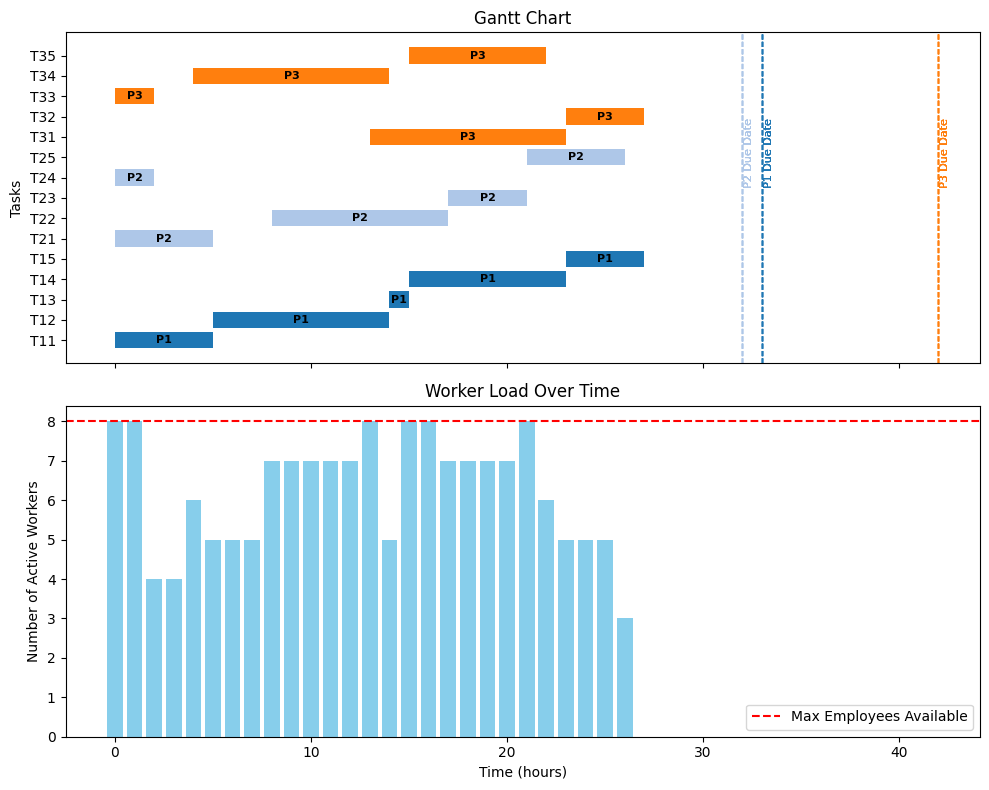

In [30]:
plot_gantt_chart_with_worker_load(schedule,projects,resources)